In [174]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pprint

from math import sqrt, fabs
from scipy.optimize import minimize
from IPython.display import Image
from matplotlib.pyplot import imshow
from random import randint

sys.path.append('../')
from map import Map
from optimizer import *
from tools import *

plt.rcParams['figure.figsize'] = [24, 16] # default is [6.0, 4.0], good value is [24, 16]
plt.rcParams['figure.dpi'] = 50 # default is 72, good value is 50


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
import data.statueofliberty as data
summits = dict(list(zip("ABCDEFGHIJKLMNOPQRSTUVWXYZ", data.summits)))
X, Y = data.dimensions

#summits, X, Y = {"A": (200, 350), "B": (200,400), "C": (300, 400), "D": (350, 350)}, 500, 500
#summits, X, Y = {"A": (200, 400), "B": (230,300), "C": (270, 300), "D": (300, 400)}, 500, 500
#summits, X, Y = {"A": (200, 400), "B": (300,400)}, 500, 500
#summits, X, Y = {"A": (200, 400), "B": (300,400), "C": (350, 400)}, 500, 500
#summits, X, Y = {"A": (200, 400), "B": (300,300), "C": (350, 400)}, 500, 500
#summits, X, Y = {"A": (200, 400), "B": (300,490), "C": (350, 400)}, 500, 500


In [176]:
summits

{'A': (315, 938),
 'B': (326, 719),
 'C': (430, 929),
 'D': (382, 724),
 'E': (940, 1425),
 'F': (1086, 1610),
 'G': (648, 929),
 'H': (686, 844)}

In [177]:
X, Y

(1352, 1726)

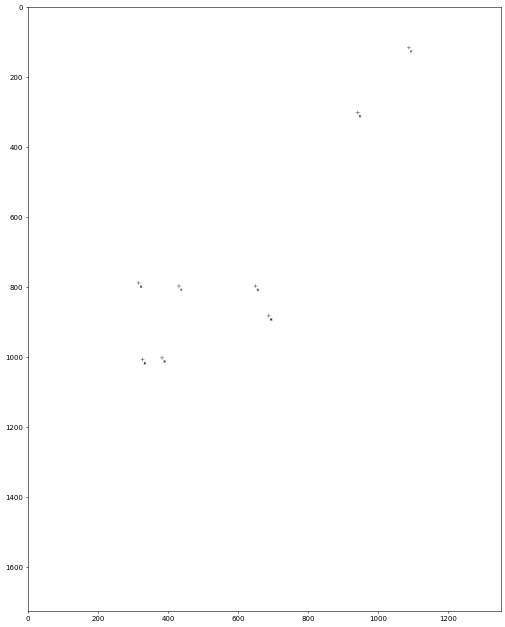

In [178]:
map = Map(dimensions=(X, Y))
for k, s in summits.items():
    map.draw_point(s, name=k)
map.show()

In [179]:
def filter_points_on_the_right(points, vectors):
    """
    filter the points that are on the right of all the vectors.
    """
    envelop = []
    for p in points:
        valid = True
        for v in vectors:
            vx, vy = v[1][0] - v[0][0], v[1][1] - v[0][1]
            px, py = p[0] - v[0][0], p[1] - v[0][1]
            cross = vx * py - vy * px
            if cross >= 1e-10:  # the wonderful world of numerical computation.
                valid = False
                break
        if valid:
            envelop.append(p)
    if len(envelop) == 0:
        raise RuntimeError(
            "Such a picture cannot be taken. "
            "Check the location and order of the points on the map and picture."
        )
    return envelop

In [180]:
def find_all_intersections(vectors):
    """
    return all vectors intersections.
    """
    intersections = set()
    for i in range(0, len(vectors)):
        for j in range(i, len(vectors)):
            inter = intersection_lines(vectors[i][0], vectors[i][1], vectors[j][0], vectors[j][1])
            if inter is not None:
                intersections.add(inter)
    return list(intersections)

In [181]:
# Compute all summit vectors (photographer is on the right of those vectors)
vectors = []
lsummits = list(summits.values())
for i in range(0, len(lsummits)):
    for j in range(i + 1, len(lsummits)):
        vectors.append((lsummits[i], lsummits[j]))

# Find all points that are part on the edge of the area where the photographer can be.
# That is, the intersections of summit vectors that are on the right of all the summit vectors.
intersections = find_all_intersections(vectors)
envelop = filter_points_on_the_right(intersections + lsummits, vectors)

# The envelop can be "open". Let's ensure it is closes by enclosing all of that in a square.
# First, let's define a square big enough to contain all of the above.
bary_summit = barycenter(summits.values())
mdist = 2* max([distance(bary_summit, p)
                for p 
                in envelop + list(summits.values())])
corners = [(bary_summit[0] - mdist, bary_summit[1] - mdist),
           (bary_summit[0] - mdist, bary_summit[1] + mdist),
           (bary_summit[0] + mdist, bary_summit[1] + mdist),
           (bary_summit[0] + mdist, bary_summit[1] - mdist)]
border_vectors = list(zip(corners, corners[1:] + corners[:1]))
 
# Let's do the same thing again with the newly added enclosing square.
close_vectors = vectors + border_vectors
close_intersections = find_all_intersections(close_vectors)
close_envelop = filter_points_on_the_right(close_intersections, close_vectors)

# Sort points (trigo order) of the (convex) envelop
bary_envelop = barycenter(close_envelop)
pabove = [p for p in close_envelop if p[1] - bary_envelop[1] >= 0]
pbelow = [p for p in close_envelop if p[1] - bary_envelop[1] < 0]
pabovesorted = sorted(
    pabove,
    key=lambda p: -(p[0] - bary_envelop[0]) / sqrt((p[0] - bary_envelop[0]) ** 2 + (p[1] - bary_envelop[1]) ** 2),
)
pbelowsorted = sorted(
    pbelow,
    key=lambda p: (p[0] - bary_envelop[0]) / sqrt((p[0] - bary_envelop[0]) ** 2 + (p[1] - bary_envelop[1]) ** 2),
)
area = pabovesorted + pbelowsorted


vectors: [((315, 938), (326, 719)), ((315, 938), (430, 929)), ((315, 938), (382, 724)), ((315, 938), (940, 1425)), ((315, 938), (1086, 1610)), ((315, 938), (648, 929)), ((315, 938), (686, 844)), ((326, 719), (430, 929)), ((326, 719), (382, 724)), ((326, 719), (940, 1425)), ((326, 719), (1086, 1610)), ((326, 719), (648, 929)), ((326, 719), (686, 844)), ((430, 929), (382, 724)), ((430, 929), (940, 1425)), ((430, 929), (1086, 1610)), ((430, 929), (648, 929)), ((430, 929), (686, 844)), ((382, 724), (940, 1425)), ((382, 724), (1086, 1610)), ((382, 724), (648, 929)), ((382, 724), (686, 844)), ((940, 1425), (1086, 1610)), ((940, 1425), (648, 929)), ((940, 1425), (686, 844)), ((1086, 1610), (648, 929)), ((1086, 1610), (686, 844)), ((648, 929), (686, 844))]
max dist: 3602.355327737081


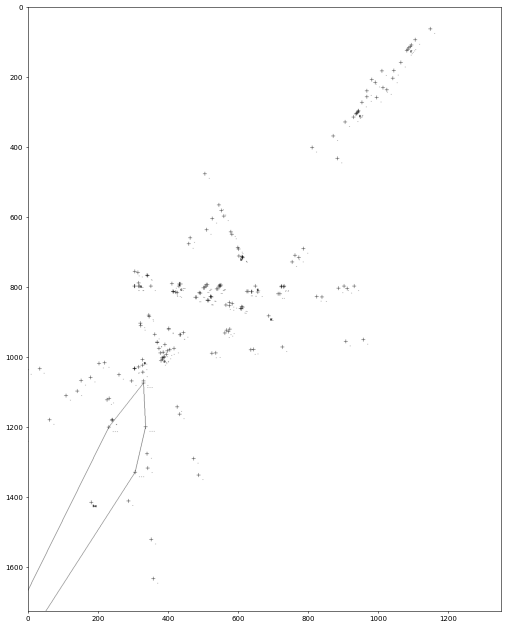

In [182]:
# Let's visualize a bit...

print("vectors:", vectors)
print("max dist:", mdist)

map.draw_point(bary_summit, name="b")
map.draw_point(bary_envelop, name="be")
for i in intersections:
    map.draw_point(i, name=" .")
for e in envelop:
    map.draw_point(e, name=" ..")
for e in close_envelop:
    map.draw_point(e, name=" ...")
for p, q in zip(area, area[1:] + area[:1]):
    map.draw_segment(p, q)
for p, q in border_vectors:
    map.draw_segment(p, q)

map.show()

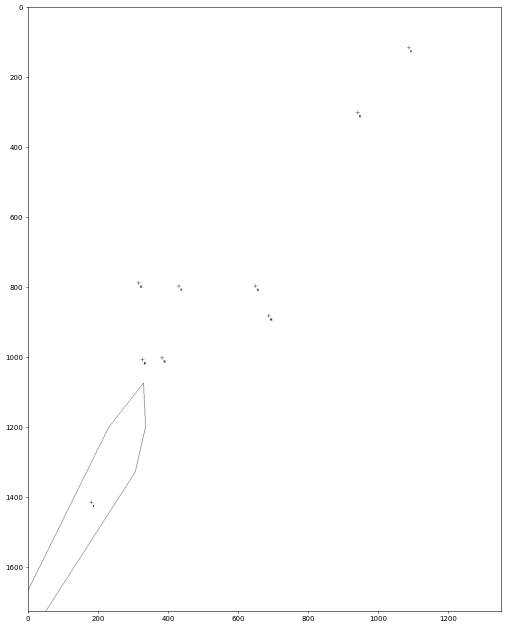

In [183]:
def photographer_area(summits, xmin=None, xmax=None, ymin=None, ymax=None):
    """
    Return the envelop (a list of point) of the area where the photograph is located.
    summits: list of summits coordinates (x, y) in the order they appears on the picture (left to right).
    xmin, ... ymax: the enclosing area of the map.
    """

    # Compute all summit vectors (photographer is on the right of those vectors)
    summit_vectors = []
    lsummits = list(summits.values())
    for i in range(0, len(lsummits)):
        for j in range(i + 1, len(lsummits)):
            summit_vectors.append((lsummits[i], lsummits[j]))

    # An enclosing zone is needed to have a "close" area
    if xmin is None:
        # Find all the corners of the area
        intersections = find_all_intersections(summit_vectors)
        envelop = filter_points_on_the_right(intersections + lsummits, summit_vectors)
        # Let's define a square centered on the barycentre and big enough to contain it all.
        bary_summit = barycenter(summits.values())
        mdist = 2 * max([distance(bary_summit, p) for p in envelop + lsummits])
        zone = [(bary_summit[0] - mdist, bary_summit[1] - mdist),
                (bary_summit[0] - mdist, bary_summit[1] + mdist),
                (bary_summit[0] + mdist, bary_summit[1] + mdist),
                (bary_summit[0] + mdist, bary_summit[1] - mdist)]
    else:
        zone = [(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)]
    
    # Find all the corners of the area
    zone_vectors = list(zip(zone, zone[1:] + zone[:1]))
    close_vectors = summit_vectors + zone_vectors
    close_intersections = find_all_intersections(close_vectors)
    close_envelop = filter_points_on_the_right(close_intersections, close_vectors)

    # Sort points (trigo order) of the (convex) envelop of the area
    bary_envelop = barycenter(close_envelop)
    pabovesorted = sorted(
        [p for p in close_envelop if p[1] - bary_envelop[1] >= 0],
        key=lambda p: -(p[0] - bary_envelop[0]) / sqrt((p[0] - bary_envelop[0]) ** 2 + (p[1] - bary_envelop[1]) ** 2),
    )
    pbelowsorted = sorted(
        [p for p in close_envelop if p[1] - bary_envelop[1] < 0],
        key=lambda p: (p[0] - bary_envelop[0]) / sqrt((p[0] - bary_envelop[0]) ** 2 + (p[1] - bary_envelop[1]) ** 2),
    )
    area = pabovesorted + pbelowsorted
    return area


# Let's visualize a bit...
map = Map(dimensions=(X, Y))
for k, s in summits.items():
    map.draw_point(s, name=k)
for p, q in zip(area, area[1:] + area[:1]):
    map.draw_segment(p, q)
map.draw_point(barycenter(area), name="I")
map.show()
